# INSTALL DEPENDENCIES

In [ ]:
# !git clone https://github.com/zjysteven/VLM-Visualizer.git

Cloning into 'VLM-Visualizer'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 120 (delta 30), reused 110 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (120/120), 3.08 MiB | 1.56 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [4]:
%cd VLM-Visualizer

/home/oanh/uncertainty/VL-Uncertainty/VLM-Visualizer


/home/oanh/miniconda3/envs/VL-Uncertainty/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import os
import sys
sys.path.append("./models")
print(sys.path)
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
%matplotlib inline
import cv2
from PIL import Image
import torch
import torch.nn.functional as F
import json

from models.llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from models.llava.conversation import conv_templates, SeparatorStyle
from models.llava.model.builder import load_pretrained_model
from models.llava.utils import disable_torch_init
from models.llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

from utils import (
    # load_image,
    # aggregate_llm_attention, aggregate_vit_attention,
    heterogenous_stack,
    show_mask_on_image
)

['/home/oanh/miniconda3/envs/VL-Uncertainty/lib/python311.zip', '/home/oanh/miniconda3/envs/VL-Uncertainty/lib/python3.11', '/home/oanh/miniconda3/envs/VL-Uncertainty/lib/python3.11/lib-dynload', '', '/home/oanh/miniconda3/envs/VL-Uncertainty/lib/python3.11/site-packages', './models', './models']


/home/oanh/miniconda3/envs/VL-Uncertainty/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class MMVet:

    def __init__(self):
        self.ds = load_dataset("whyu/mm-vet")

    def obtain_size(self):
        return len(self.ds['test'])

    def retrieve(self, idx):
        row = self.ds['test'][idx]
        question = f"{row['question']}\nNOTE: Provide only the final answer. Do not provide unrelated details."
        result = {
            'idx': idx,
            'img': row['image'],
            'question': question,
            'gt_ans': row['answer'],
        }
        return result

if __name__ == "__main__":
    benchmark = MMVet()
    print(benchmark.retrieve(0))

In [ ]:

def get_description_from_file(file_path, idx) -> str:
    file_path = "/home/oanh/uncertainty/VL-Uncertainty/image_descriptions/" +  file_path
    with open(file_path) as f:
        description = json.load(f)
    # print(description)
    return description[f'{idx}']['image_description']

# RUN MODEL TO GENERATE TOKEN

In [ ]:
# ===> specify the model path
model_path = "llava-hf/llava-1.5-7b-hf"

# load the model
load_8bit = True
load_4bit = False
device = "cuda" if torch.cuda.is_available() else "cpu"

disable_torch_init()

model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path,
    None, # model_base
    model_name,
    load_8bit,
    load_4bit,
    device=device,
    # local_files_only = True
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


AttributeError: 'dict' object has no attribute 'to_dict'

In [ ]:
index = 62
print(MMVet().retrieve(index))
image = MMVet().retrieve(index)['img']
prompt = MMVet().retrieve(index)['question']
# prompt = prompt + "\nNOTE: Provide only the final answer. Do not provide unrelated details."
image_tensor, images = process_images([image], image_processor, model.config)
image = images[0]
image_size = image.size

# print(prompt)

In [ ]:
def add_description_to_prompt(prompt, index):
    ''' Add the description to the prompt
    prompt: str
    index: int (index of the sample)
    '''
    description = get_description_from_file('MMVet_2025_01_29_prompt4.json', index)
    print(description)
    description = "Description: " + "The first equation, labeled \"1)\", is 8x + 11 = 4x + 14."
    ori_prompt = "Based on the provided photo, " + prompt
    text_only_prompt = description + "\nBased on the provided description, " + prompt
    text_support_prompt = description + "\nBased on the provided description and the photo, " + prompt
    return ori_prompt, text_only_prompt, text_support_prompt

In [ ]:
# # LOAD IMAGE
# # image_path_or_url = "https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcT-n9OWEWQULu4TUjpRIPVvi2NqVawi-W6XdgILGxQrcTt9QG5Q"
# # image = load_image(image_path_or_url)
# image = Image.open("sample_image.jpg")
# image_tensor, images = process_images([image], image_processor, model.config)
# image = images[0]
# image_size = image.size
# # image.save("sample_image.jpg")


What is the color of the hat worn by the person in the front left?
NOTE: Provide only the final answer. Do not provide unrelated details.


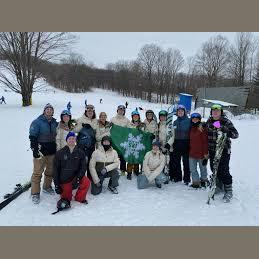

USER: <image>
What is the color of the hat worn by the person in the front left? ASSISTANT:


In [13]:
# # ===> specify the image path or url and the prompt text
# description = "The image is a photograph showing three price tags for different bottles of wine. From left to right, the tags display \"NORTHSTAR MERLOT\" with a price of 139.99, \"MOET & CHANDON IMPERIAL\" with a price of 114.99, and \"CHATEAU ST MICHELLE COLD CREEK CABERNET\" with a price of 109.99. Each tag also includes additional text about the wine."
# prompt_text = description + "\nBased on the description and image. What is the total price for a bottle of Merlot and a bottle of Cabernet shown in the image?\nNOTE: Provide only the final answer. Do not provide unrelated details."
# prompt_text = "What is the total price for a bottle of Merlot and a bottle of Cabernet shown in the image?\nNOTE: Provide only the final answer. Do not provide unrelated details."
# description = ""
# description = "This is a photograph of a group of people in a snowy outdoor setting. The group is arranged in two rows, with some individuals standing and others kneeling. The person in the front left is wearing a red hat. The group is holding a green flag with white text."
# prompt_text  = description + "\nBased on the description and image. What is the color of the hat worn by the person in the front left?"
prompt_text = "What is the color of the hat worn by the person in the front left?"
prompt = prompt_text + "\nNOTE: Provide only the final answer. Do not provide unrelated details."
print(prompt)
################################################
# preparation for the generation
# unlikely that you need to change anything here
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

conv = conv_templates[conv_mode].copy()
if "mpt" in model_name.lower():
    roles = ('user', 'assistant')
else:
    roles = conv.roles

if type(image_tensor) is list:
    image_tensor = [image.to(model.device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(model.device, dtype=torch.float16)

if model.config.mm_use_im_start_end:
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + prompt_text
else:
    inp = DEFAULT_IMAGE_TOKEN + '\n' + prompt_text

conv.append_message(conv.roles[0], inp)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()
# manually removing the system prompt here
# otherwise most attention will be somehow put on the system prompt
prompt = prompt.replace(
    "A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. ",
    ""
)

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(model.device)
################################################

display(image)
# print(prompt_text)
print(prompt)

In [14]:
# generate the response
with torch.inference_mode():
    outputs = model.generate(
        input_ids,
        images=image_tensor,
        image_sizes=[image_size],
        do_sample=True,
        temperature = 0.3,
        max_new_tokens=128,
        use_cache=True,
        return_dict_in_generate=True,
        output_attentions=True,
    )
# print(tokenizer.decode(outputs['sequences']))
# print(type(outputs['sequences']))
text = tokenizer.batch_decode(outputs["sequences"])
print(len(outputs['sequences']))
text = text[0].split('<')[:-1]
text = " ".join(text)
print(text)

1
The color of the hat worn by the person in the front left is blue.


# PLOT OUT LLM ATTENTION

In [15]:
# 14 * 32 * [1, 32, 604, 604]
# sequence_len * num_layer * [batch_size, num_heads, sequence_length, sequence_length]

print("sequence_len:",len(outputs['sequences'][0]))
print("len_of_output[attention]:", len(outputs['attentions']))
print("num_of_layer:", len(outputs['attentions'][0]))
print(outputs['attentions'][0][0].shape)


sequence_len: 17
len_of_output[attention]: 17
num_of_layer: 32
torch.Size([1, 32, 604, 604])


In [16]:
def aggregate_llm_attention(attn):
    '''Extract average attention vector'''
    avged = []
    for layer in attn[0:5]:
        layer_attns = layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)
        vec = torch.concat((
            # We zero the first entry because it's what's called
            # null attention (https://aclanthology.org/W19-4808.pdf)
            torch.tensor([0.]),
            # usually there's only one item in attns_per_head but
            # on the first generation, there's a row for each token
            # in the prompt as well, so take [-1]
            attns_per_head[-1][1:].cpu(),
            # attns_per_head[-1].cpu(),
            # add zero for the final generated token, which never
            # gets any attention
            torch.tensor([0.]),
        ))
        avged.append(vec / vec.sum())
    return torch.stack(avged).mean(dim=0)

In [17]:
# constructing the llm attention matrix
# output
aggregated_prompt_attention = []
for i, layer in enumerate(outputs["attentions"][0]):
    layer_attns = layer.squeeze(0)
    attns_per_head = layer_attns.mean(dim=0)
    cur = attns_per_head[:-1].cpu().clone()
    # following the practice in `aggregate_llm_attention`
    # we are zeroing out the attention to the first <bos> token
    # for the first row `cur[0]` (corresponding to the next token after <bos>), however,
    # we don't do this because <bos> is the only token that it can attend to
    cur[1:, 0] = 0.
    cur[1:] = cur[1:] / cur[1:].sum(-1, keepdim=True)
    aggregated_prompt_attention.append(cur)
aggregated_prompt_attention = torch.stack(aggregated_prompt_attention).mean(dim=0)

# llm_attn_matrix will be of torch.Size([N, N])
# where N is the total number of input (both image and text ones) + output tokens
llm_attn_matrix = heterogenous_stack(
    [torch.tensor([1])]
    + list(aggregated_prompt_attention)
    + list(map(aggregate_llm_attention, outputs["attentions"]))
)

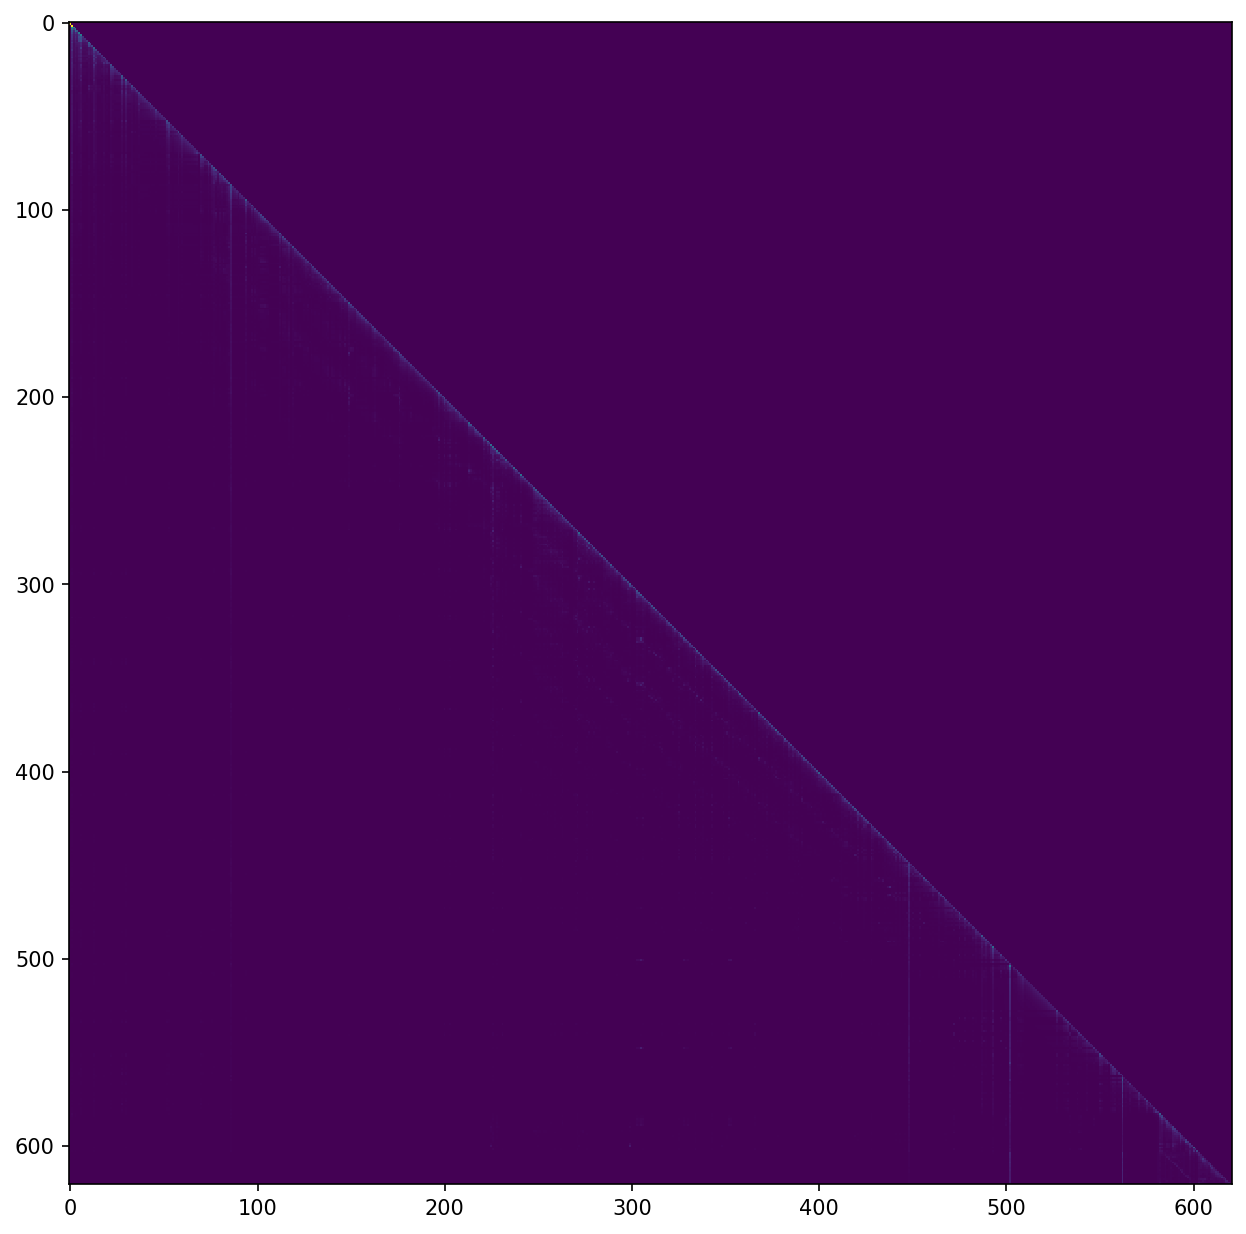

In [18]:
# visualize the llm attention matrix
# ===> adjust the gamma factor to enhance the visualization
#      higer gamma brings out more low attention values
gamma_factor = 1
enhanced_attn_m = np.power(llm_attn_matrix.numpy(), 1 / gamma_factor)

fig, ax = plt.subplots(figsize=(10, 20), dpi=150)
ax.imshow(enhanced_attn_m, vmin=enhanced_attn_m.min(), vmax=enhanced_attn_m.max(), interpolation="nearest")

In [19]:
# Print out vision encoder of llava
print(type(model.get_vision_tower()))
print(model.get_vision_tower())

<class 'llava.model.multimodal_encoder.clip_encoder.CLIPVisionTower'>
CLIPVisionTower(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    

## GET TEXTUAL AND VISUAL IDS

THE FLOW: 

Image -> Vision Tower (separately) -> image_emb (This emb does not depend on the text component)

Text -> Text Tower (separately) -> text_emb (seperately)


image_emb combines text_emb (cross-attention or something else) -> Answers

In [20]:
# identify length or index of tokens
input_token_len = model.get_vision_tower().num_patches + len(input_ids[0]) - 1 # -1 for the <image> token
vision_token_start = len(tokenizer(prompt.split("<image>")[0], return_tensors='pt')["input_ids"][0])
vision_token_end = vision_token_start + model.get_vision_tower().num_patches
output_token_len = len(outputs["sequences"][0])
output_token_start = input_token_len
output_token_end = input_token_len + output_token_len

In [37]:
print("input_len:", input_token_len)
print("start_of_vision_token:" ,vision_token_start)
print("end_of_vision_token:",vision_token_end)
print("vision_token_len:", vision_token_end - vision_token_start)
print("output_len:",output_token_len)
print("start_of_output_token:", output_token_start)
print("end_of_output_token:",output_token_end)

input_len: 604
start_of_vision_token: 5
end_of_vision_token: 581
vision_token_len: 576
output_len: 17
start_of_output_token: 604
end_of_output_token: 621


In [38]:
print(outputs['sequences'][0])
tokenizer.decode(outputs['sequences'][0])
# tokenizer.decode(2)

tensor([  450,  2927,   310,   278,  3056, 28043,   491,   278,  2022,   297,
          278,  4565,  2175,   338,  7254, 29889,     2], device='cuda:0')


'The color of the hat worn by the person in the front left is blue.</s>'

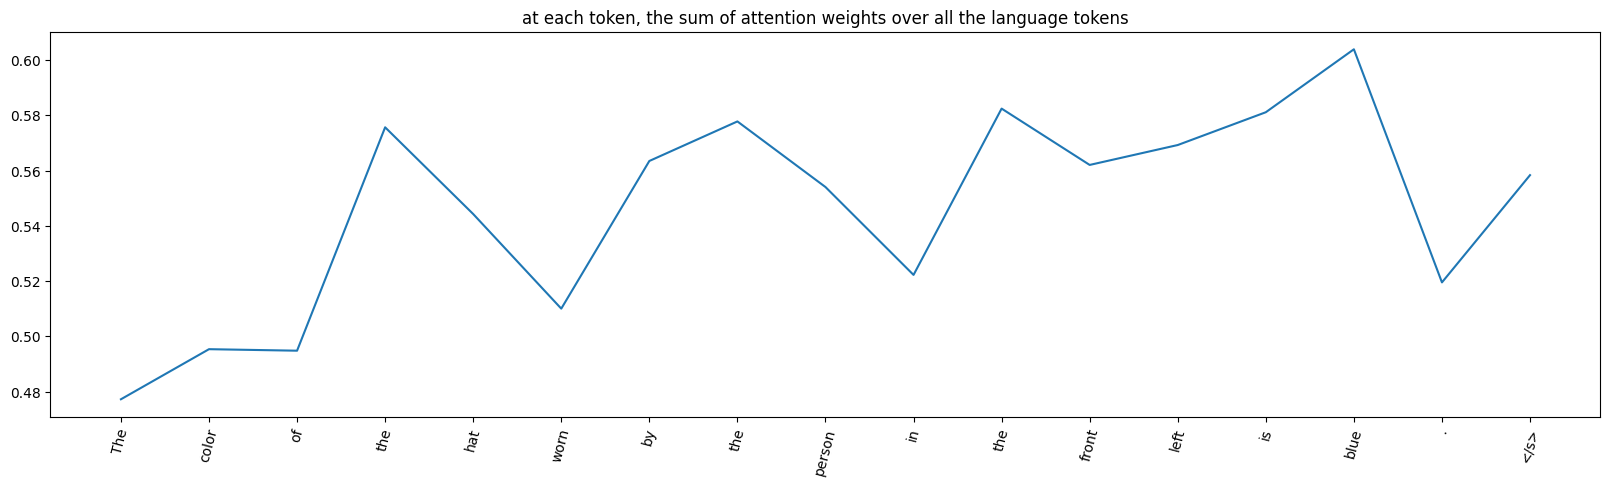

In [23]:
# look at the attention weights over the vision tokens
overall_attn_weights_over_lang_tokens = []
for i, (row, token) in enumerate(
    zip(
        llm_attn_matrix[input_token_len:],
        outputs["sequences"][0].tolist()
    )
):
    # print(
    #     i + input_token_len,
    #     f"{tokenizer.decode(token, add_special_tokens=False).strip():<15}",
    #     f"{row[vision_token_start:vision_token_end].sum().item():.4f}"
    # )

    overall_attn_weights_over_lang_tokens.append(
        row[:vision_token_start].sum().item() + row[vision_token_end:].sum().item()
    )

# plot the trend of attention weights over the vision tokens
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(overall_attn_weights_over_lang_tokens)
ax.set_xticks(range(len(overall_attn_weights_over_lang_tokens)))
ax.set_xticklabels(
    [tokenizer.decode(token, add_special_tokens=False).strip() for token in outputs["sequences"][0].tolist()],
    rotation=75
)
ax.set_title("at each token, the sum of attention weights over all the language tokens");

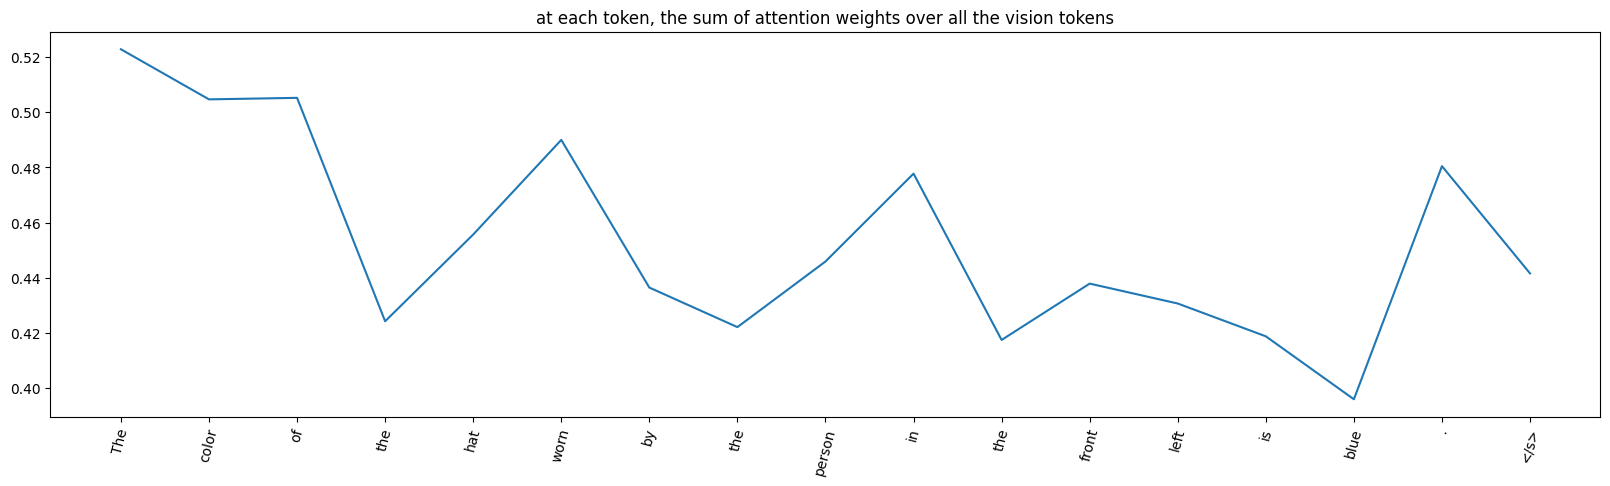

In [24]:
# look at the attention weights over the vision tokens
overall_attn_weights_over_vis_tokens = []
for i, (row, token) in enumerate(
    zip(
        llm_attn_matrix[input_token_len:],
        outputs["sequences"][0].tolist()
    )
):
    # print(
    #     i + input_token_len,
    #     f"{tokenizer.decode(token, add_special_tokens=False).strip():<15}",
    #     f"{row[vision_token_start:vision_token_end].sum().item():.4f}"
    # )

    overall_attn_weights_over_vis_tokens.append(
        row[vision_token_start:vision_token_end].sum().item()
    )

# plot the trend of attention weights over the vision tokens
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(overall_attn_weights_over_vis_tokens)
ax.set_xticks(range(len(overall_attn_weights_over_vis_tokens)))
ax.set_xticklabels(
    [tokenizer.decode(token, add_special_tokens=False).strip() for token in outputs["sequences"][0].tolist()],
    rotation=75
)
ax.set_title("at each token, the sum of attention weights over all the vision tokens");

In [25]:
print(prompt)

USER: <image>
What is the color of the hat worn by the person in the front left? ASSISTANT:


## DISCOVER TEXTUAL AND VISUAL ATTENTION

### TEXTUAL ATTENTION

In [ ]:
def decoded_tokens_with_image_patches(indice, vision_token_start, vision_token_end, input_ids, outputs, output_token_start):
  # input_token_len = vision_token_end - vision_token_start + len(input_ids[0]) - 1 # -1 for the <image> token
  generated_tokens = outputs["sequences"][0].tolist()
  if indice < vision_token_start:
    return tokenizer.decode(input_ids[0][indice], add_special_tokens=False).strip()
  elif vision_token_start <= indice < vision_token_end:
    return "<IMAGE TOKEN>"
  elif vision_token_end <= indice < output_token_start : #and indice - vision_token_end < len(input_ids[0]): #Fix: Add a condition to check if indice - vision_token_end is within the bounds of input_ids[0]
    return tokenizer.decode(input_ids[0][indice - (vision_token_end - vision_token_start)], add_special_tokens=False).strip() #Fix: Change indice - vision_token_end to indice - (vision_token_end - vision_token_start) to get the correct index within input_ids[0]
  else:
    return tokenizer.decode(generated_tokens[indice - output_token_start], add_special_tokens=False).strip()

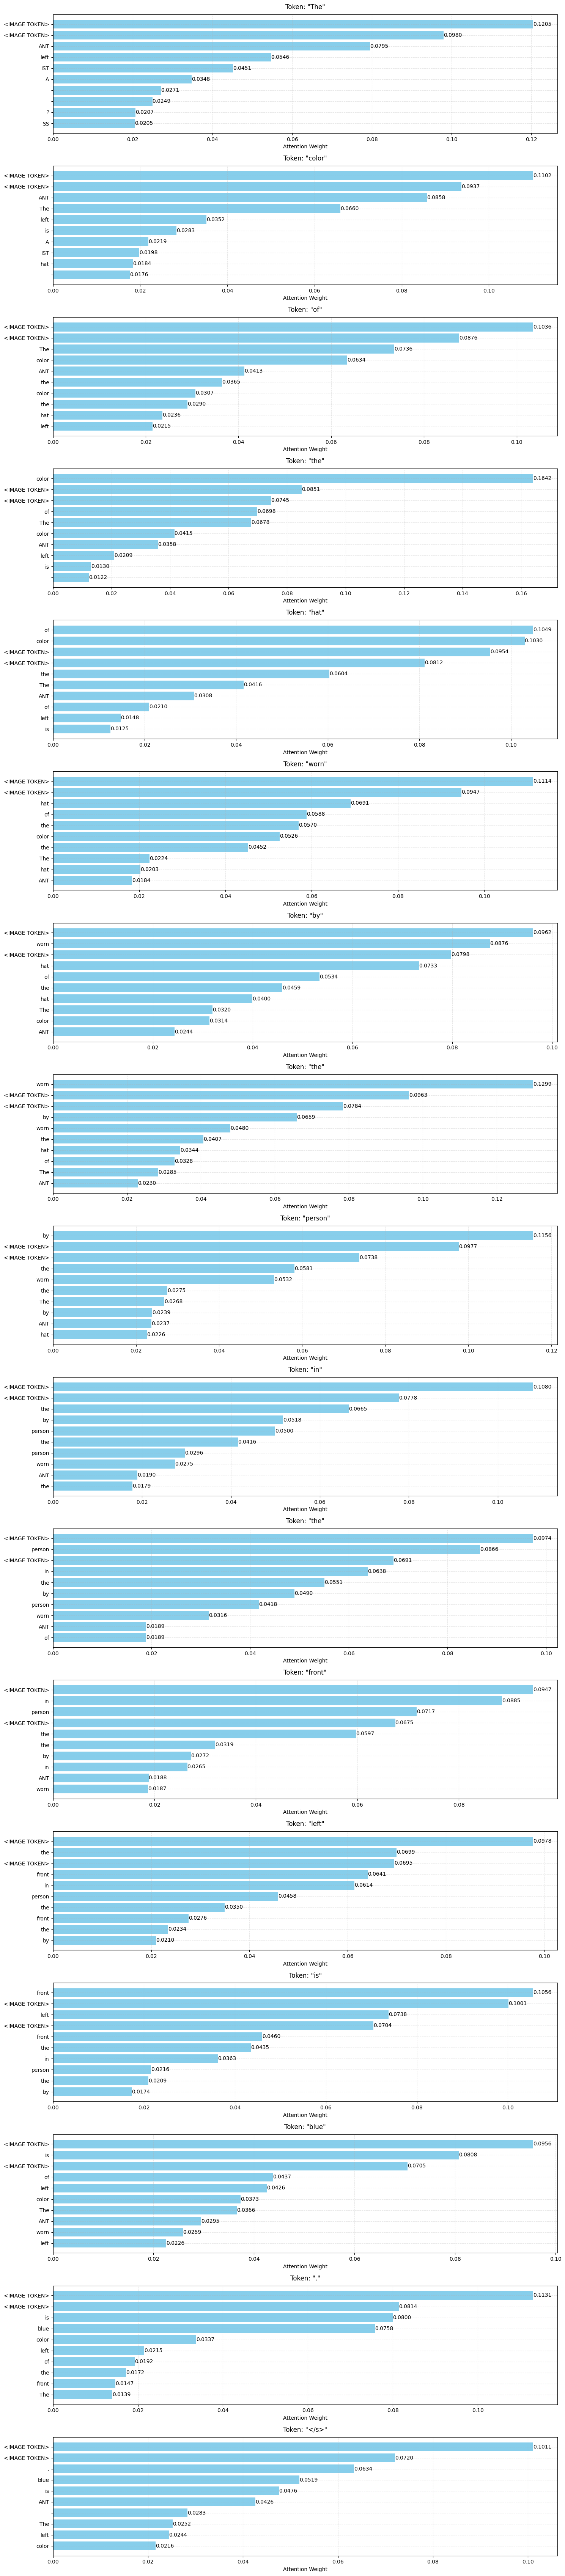

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_per_word_attention(
    llm_attn_matrix,
    input_token_len,
    vision_token_start,
    vision_token_end,
    outputs,
    tokenizer
):
    """
    Plot detailed attention weights for each generated token showing attention to all other tokens.

    Args:
        llm_attn_matrix: Attention matrix from the model
        input_token_len: Length of input tokens
        vision_token_start: Start index of vision tokens
        vision_token_end: End index of vision tokens
        outputs: Model outputs containing sequences
        tokenizer: Tokenizer for decoding tokens
    """
    # Get generated tokens and their decoded values
    generated_tokens = outputs["sequences"][0].tolist()
    decoded_tokens = [tokenizer.decode(token, add_special_tokens=False).strip()
                     for token in generated_tokens]

    # Extract attention weights for non-vision tokens
    attention_weights = []
    for row in llm_attn_matrix[input_token_len:]:
        # Get attention weights for non-vision tokens
        non_vision_weights = np.concatenate([
            row[:vision_token_start].numpy(),
            row[vision_token_end:].numpy()
        ])
        attention_weights.append(non_vision_weights)

    attention_weights = np.array(attention_weights)

    # Create heatmap
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.imshow(attention_weights, cmap='YlOrRd', aspect='auto')

    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Attention Weight', rotation=270, labelpad=15)

    # Set labels
    ax.set_xlabel('Input Tokens')
    ax.set_ylabel('Generated Tokens')

    # Set x-axis labels (input tokens)
    num_tokens = attention_weights.shape[1]
    # step = max(1, num_tokens // 20)  # Show at most 20 tokens to avoid overcrowding
    step = 1
    ax.set_xticks(np.arange(0, num_tokens, step))
    ax.set_xticklabels([f'{tokenizer.decode(i)}' for i in range(0, num_tokens, step)],
                       rotation=45, ha='right')

    # Set y-axis labels (generated tokens)
    ax.set_yticks(np.arange(len(decoded_tokens)))
    ax.set_yticklabels(decoded_tokens)

    # Add title
    plt.title('Attention Weights per Generated Token', pad=20)

    # Adjust layout
    plt.tight_layout()

    return fig, ax

def plot_attention_word_analysis(
    llm_attn_matrix,
    input_token_len,
    vision_token_start,
    vision_token_end,
    outputs,
    tokenizer,
    top_k=5
):
    """
    Create detailed analysis plots showing top attended tokens for each generated token.

    Args:
        llm_attn_matrix: Attention matrix from the model
        input_token_len: Length of input tokens
        vision_token_start: Start index of vision tokens
        vision_token_end: End index of vision tokens
        outputs: Model outputs containing sequences
        tokenizer: Tokenizer for decoding tokens
        top_k: Number of top attention weights to show
    """
    generated_tokens = outputs["sequences"][0].tolist()
    decoded_tokens = [tokenizer.decode(token, add_special_tokens=False).strip()
                     for token in generated_tokens]

    num_tokens = len(decoded_tokens)
    fig, axes = plt.subplots(num_tokens, 1, figsize=(15, 4*num_tokens))
    if num_tokens == 1:
        axes = [axes]

    for idx, (row, token, ax) in enumerate(zip(
        llm_attn_matrix[input_token_len:],
        decoded_tokens,
        axes
    )):
        # Get non-vision attention weights
        all_weights = np.concatenate([
            row.numpy(),
        ])

        # Get top-k indices and values
        top_k_indices = np.argsort(all_weights)[-top_k:]
        top_k_values = all_weights[top_k_indices]

        # Create bar plot
        bars = ax.barh(range(top_k), top_k_values, color='skyblue')

        # Add value labels
        for i, (value, bar) in enumerate(zip(top_k_values, bars)):
            ax.text(value, i, f'{value:.4f}',
                   va='center', ha='left', fontsize=10)

        # Customize plot
        ax.set_title(f'Token: "{token}"', fontsize=12, pad=10)
        ax.set_xlabel('Attention Weight')
        ax.set_yticks(range(top_k))

        # decoded_tokens = tokenizer.decode(top_k_indices,  add_special_tokens=False)
        # print(top_k_indices)
        ax.set_yticklabels([f'{decoded_tokens_with_image_patches(i, vision_token_start, vision_token_end, input_ids, outputs, output_token_start)}' for i in top_k_indices.tolist()])
        # print(tokenizer.decode([177] ))
        ax.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    return fig, axes

# Example usage:
# Create both visualizations
# fig1, ax1 = plot_per_word_attention(
#     llm_attn_matrix,
#     input_token_len,
#     vision_token_start,
#     vision_token_end,
#     outputs,
#     tokenizer
# )

fig2, ax2 = plot_attention_word_analysis(
    llm_attn_matrix,
    input_token_len,
    vision_token_start,
    vision_token_end,
    outputs,
    tokenizer,
    top_k=10
)

plt.show()

### VISUAL ATTENTION

Below we aim to visualize the attention w.r.t. the input image. First we obtain a single attention map from the vision encoder (ViT) by again averaging the attention maps across heads and layers. I have tried a supposedly more reasonable method of [attention rollout](https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py), i.e. multiplying the attention matrices over each layer, but never got sensible results. See the `aggregate_vit_attention` in `utils.py` for details.


Then, for each generated token of LLM, we compute the weighted average of the attention map of each vision token to get an aggregated attention map over the input image for that generated token. Finally we resize and overlay the attention map on the input image.

In [ ]:
print(len(model.get_vision_tower().image_attentions))
print((model.get_vision_tower().image_attentions[0].shape))

24
torch.Size([1, 16, 577, 577])


In [29]:
def aggregate_vit_attention(attn, select_layer=-2, all_prev_layers=True):
    '''Assuming LLaVA-style `select_layer` which is -2 by default'''
    print("fixed")
    if all_prev_layers:
        avged = []
        # print('haha')
        for i, layer in enumerate(attn):
            if i > len(attn) + select_layer:
                break
            layer_attns = layer.squeeze(0)
            attns_per_head = layer_attns.mean(dim=0)
            vec = attns_per_head[1:, 1:].cpu() # the first token is <CLS>
            # print(type(vec))
            # print(vec.shape)
            avged.append(vec / vec.sum(-1, keepdim=True))
        return torch.stack(avged).mean(dim=0)
    else:
        layer = attn[select_layer]
        layer_attns = layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)
        vec = attns_per_head[1:, 1:].cpu()
        return vec / vec.sum(-1, keepdim=True)


In [30]:
print(prompt)

USER: <image>
What is the color of the hat worn by the person in the front left? ASSISTANT:


fixed


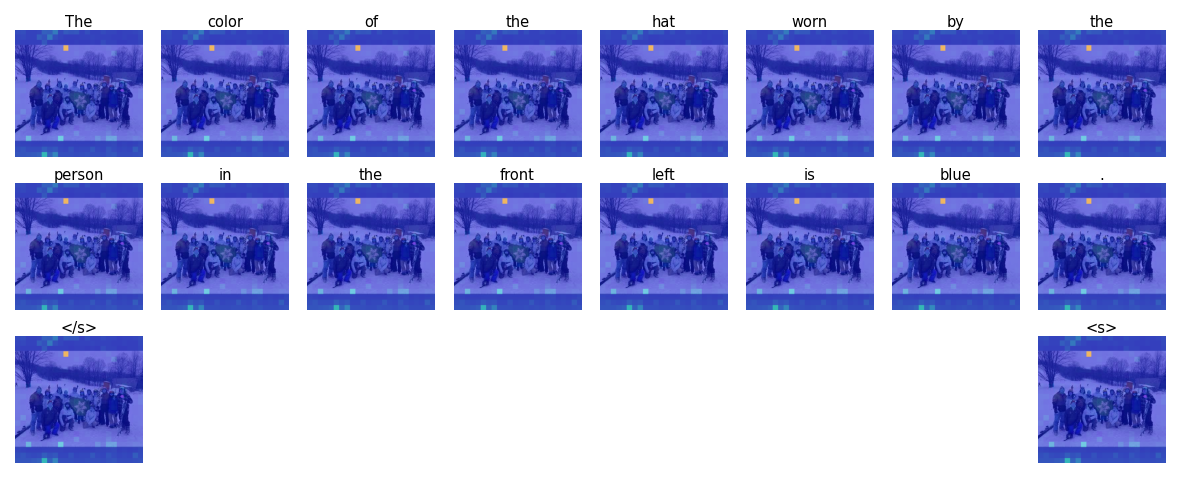

In [31]:
# connect with the vision encoder attention
# to visualize the attention over the image

# vis_attn_matrix will be of torch.Size([N, N])
# where N is the number of vision tokens/patches
# `all_prev_layers=True` will average attention from all layers until the selected layer
# otherwise only the selected layer's attention will be used

vis_attn_matrix = aggregate_vit_attention(
    model.get_vision_tower().image_attentions,
    select_layer=model.get_vision_tower().select_layer,
    all_prev_layers=True,
)
grid_size = model.get_vision_tower().num_patches_per_side

num_image_per_row = 8
image_ratio = image_size[0] / image_size[1]
num_rows = output_token_len // num_image_per_row + (1 if output_token_len % num_image_per_row != 0 else 0)
fig, axes = plt.subplots(
    num_rows, num_image_per_row,
    figsize=(10, (10 / num_image_per_row) * image_ratio * num_rows),
    dpi=150
)
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# whether visualize the attention heatmap or
# the image with the attention heatmap overlayed
vis_overlayed_with_attn = True

output_token_inds = list(range(output_token_start, output_token_end))
overall_attn_weights_over_vis_tokens = []

for i, ax in enumerate(axes.flatten()):
    if i >= output_token_len:
        ax.axis("off")
        continue

    target_token_ind = output_token_inds[i]
    # print(llm_attn_matrix.shape)
    attn_weights_over_vis_tokens = llm_attn_matrix[target_token_ind][vision_token_start:vision_token_end]
    attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.sum()
    # print(attn_weights_over_vis_tokens.shape)
    overall_attn_weights_over_vis_tokens.append(attn_weights_over_vis_tokens)
    attn_over_image = []
    for weight, vis_attn in zip(attn_weights_over_vis_tokens, vis_attn_matrix):
        vis_attn = vis_attn.reshape(grid_size, grid_size)
        # vis_attn = vis_attn / vis_attn.max()
        attn_over_image.append(vis_attn * weight)
    attn_over_image = torch.stack(attn_over_image).sum(dim=0)
    attn_over_image = attn_over_image / attn_over_image.max()

    attn_over_image = F.interpolate(
        attn_over_image.unsqueeze(0).unsqueeze(0),
        size=image.size,
        mode='nearest',
        # mode='bicubic', align_corners=False
    ).squeeze()

    np_img = np.array(image)[:, :, ::-1]
    img_with_attn, heatmap = show_mask_on_image(np_img, attn_over_image.numpy())
    ax.imshow(heatmap if not vis_overlayed_with_attn else img_with_attn)
    ax.set_title(
        tokenizer.decode(outputs["sequences"][0][i], add_special_tokens=False).strip(),
        fontsize=7,
        pad=1
    )
    ax.axis("off");

attn_over_image = F.interpolate(
    attn_over_image.unsqueeze(0).unsqueeze(0),
    size=image.size,
    mode='nearest',
    # mode='bicubic', align_corners=False
).squeeze()

np_img = np.array(image)[:, :, ::-1]
img_with_attn, heatmap = show_mask_on_image(np_img, attn_over_image.numpy())
ax.imshow(heatmap if not vis_overlayed_with_attn else img_with_attn)
ax.set_title(
    label="<s>",
    fontsize=7,
    pad=1
)
ax.axis("off");

torch.Size([576])


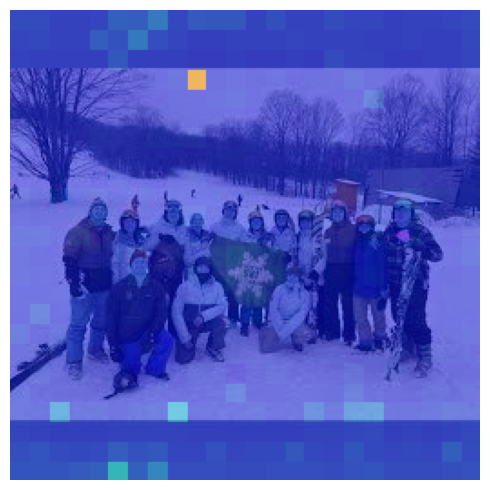

In [32]:
overall_attn_weights_over_vis_tokens = torch.stack(overall_attn_weights_over_vis_tokens)
overall_attn_weights_over_vis_tokens = overall_attn_weights_over_vis_tokens.mean(dim=0)
print(overall_attn_weights_over_vis_tokens.shape)
attn_over_image = []
for weight, vis_attn in zip(overall_attn_weights_over_vis_tokens, vis_attn_matrix):
    vis_attn = vis_attn.reshape(grid_size, grid_size)
    attn_over_image.append(vis_attn * weight)

# Aggregate and normalize attention map
attn_over_image = torch.stack(attn_over_image).sum(dim=0)
attn_over_image = attn_over_image / attn_over_image.max()

# Interpolate to image size
attn_over_image = F.interpolate(
    attn_over_image.unsqueeze(0).unsqueeze(0),
    size=image.size,
    mode='nearest'
).squeeze()

# Convert image to numpy array (assuming BGR to RGB conversion if needed)
np_img = np.array(image)[:, :, ::-1]

# Create figure and visualize
plt.figure(figsize=(5, 5))

# Show either overlaid image or heatmap
if vis_overlayed_with_attn:
    img_with_attn, _ = show_mask_on_image(np_img, attn_over_image.numpy())
    plt.imshow(img_with_attn)
else:
    _, heatmap = show_mask_on_image(np_img, attn_over_image.numpy())
    plt.imshow(heatmap)

plt.axis('off')
plt.tight_layout()
plt.show()

# FINDINGS NOTES

Finding: even with different answers sampled from the VLM, the attention map on the provided image is still the same (with description provided case) as the image based less on the visual token (the answer highest depend is only < 0.22)

Provided the description, the answer become less depends on the image. (Even though the description contains information for answer or not? Yes and it may not look at the image also.) -> Try to plot out also the attention on language part

Llava use the same visual encoder like CLIP (which follows VIT architecture.)
QWEN-VL visual encoder is also use VIT-architecture like

In [ ]:
# Testing a again of uncertainty in earlier layer of VLM. There must be differences somewhere.
# Checking again the code of plotting out attention of VIT model (the architecture of LLaVa also)